<a href="https://colab.research.google.com/github/heiliaavola/chemical-analysis-quantification/blob/main/Chemical_analysis_quantification_Machine_Learning_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chemical Analysis Quantification

##Machine Learning approach

Annabel Hiiu & Anett Sandberg

###Exploring the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [ ]:
data = pd.read_csv('data_ready_231029.csv')
data.head()

,lab,compound,sample_type,RT,sample,peak_area,note,c_real_M
0,L1,Amitrole,cal,0.72,cal1,2.856002e+08,non-linear,6.250000e-06
1,L1,Amitrole,cal,0.72,cal2,1.030577e+08,non-linear,2.580000e-06
2,L1,Amitrole,cal,0.72,cal3,6.593301e+07,non-linear,1.340000e-06
3,L1,Amitrole,cal,0.72,cal4,3.805867e+07,non-linear,7.780000e-07
4,L1,Amitrole,cal,0.72,cal5,1.340538e+07,linear,2.350000e-07


In [ ]:
print('Column "lab": ')
unique_values_lab = data['lab'].unique() #Data from 19 labs
print(f'Data from {len(unique_values_lab)} different laboratories.\n')

print('Column "compound": ')
unique_values_compound = data['compound'].unique() #About 52 different chemicals
print(f'Information about {len(unique_values_compound)} different chemical compounds.\n')

print('Column "sample_type": ')
unique_values_sample_type = data['sample_type'].unique() #All points are calibration points, so this column is not informative
print(unique_values_sample_type)
print('All points are calibration points, so this column is not informative.\n')

print('Column "sample": ')
unique_values_sample = data['sample'].unique() #Each graph has up to 6 points.
print(unique_values_sample)
print(f'Each group has up to {len(unique_values_sample)} datapoints.\n')

print('Column "c_real_M": ')
unique_values_c = data['c_real_M'].unique()
print(f'Concentration values range from {min(unique_values_c)}M to {max(unique_values_c)}M.')
print('Therefore this column should be normalised.')


Column "lab": 
Data from 19 different laboratories.

Column "compound": 
Information about 52 different chemical compounds.

Column "sample_type": 
['cal']
All points are calibration points, so this column is not informative.

Column "sample": 
['cal1' 'cal2' 'cal3' 'cal4' 'cal5' 'cal6']
Each group has up to 6 datapoints.

Column "c_real_M": 
Concentration values range from 8.49e-10M to 8.9e-06M.
Therefore this column should be normalised.


###Preprocessing the data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data_dropped = data.drop(columns=['sample_type'])

data_cleaned = data_dropped.dropna()
print(f'Before had {len(data)} rows and after dropping rows, where concentration is missing, have {len(data_cleaned)} rows.')

# Normalizing 'c_real_M' within each group by dividing by the maximum value in the group
data_grouped = data_cleaned.groupby(['lab', 'compound'])
data_cleaned['c_real_M_group_norm'] = data_grouped['c_real_M'].transform(lambda x: x / x.max())
data_cleaned = data_cleaned.drop(columns=['c_real_M'])

# Encoding multiple columns
le = LabelEncoder()
for col in ['lab', 'compound', 'sample']:
    if data_cleaned[col].dtype == 'object':
        data_cleaned[col] = le.fit_transform(data_cleaned[col])

#Encoding y values
data_cleaned['note'] = data_cleaned['note'].map({'non-linear': 0, 'linear': 1})

data_cleaned.head()

Before had 3938 rows and after dropping rows, where concentration is missing, have 3926 rows.


<ipython-input-7-34d88a42814b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,lab,compound,RT,sample,peak_area,note,c_real_M_group_norm
0,0,0,0.72,0,2.856002e+08,0,1.00000
1,0,0,0.72,1,1.030577e+08,0,0.41280
2,0,0,0.72,2,6.593301e+07,0,0.21440
3,0,0,0.72,3,3.805867e+07,0,0.12448
4,0,0,0.72,4,1.340538e+07,1,0.03760


####Splitting the data (keeping points of same compound measured in same labs in either training or validation set)

In [ ]:
groups = data_cleaned.groupby(['lab', 'compound'])
# Get the list of unique group identifiers (lab, compound)
group_identifiers = list(groups.groups.keys())

# Shuffle the group identifiers
np.random.shuffle(group_identifiers)

train_indices = []
test_indices = []
for group_id in group_identifiers:
    group = groups.get_group(group_id)
    if np.random.rand() < 0.8:  # 80% chance to go into training set
        train_indices.extend(group.index)
    else:
        test_indices.extend(group.index)

train_data = data_cleaned.loc[train_indices]
test_data = data_cleaned.loc[test_indices]

X_train = train_data.drop(['note'], axis=1)
y_train = train_data['note']
X_val = test_data.drop(['note'], axis=1)
y_val = test_data['note']

###Single Learning Approach

####Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy='uniform', random_state=42)
dummy_model.fit(X_train, y_train)
predictions_dummy = dummy_model.predict(X_val)

print(f"Accuracy of Dummy Classifier is {round(accuracy_score(y_val, predictions_dummy),3)*100}%.")
print("Classification Report (Dummy Classifier):\n", classification_report(y_val, predictions_dummy))

Accuracy of Dummy Classifier is 52.1%.
Classification Report (Dummy Classifier):
               precision    recall  f1-score   support

           0       0.45      0.51      0.48       367
           1       0.58      0.53      0.56       476

    accuracy                           0.52       843
   macro avg       0.52      0.52      0.52       843
weighted avg       0.53      0.52      0.52       843



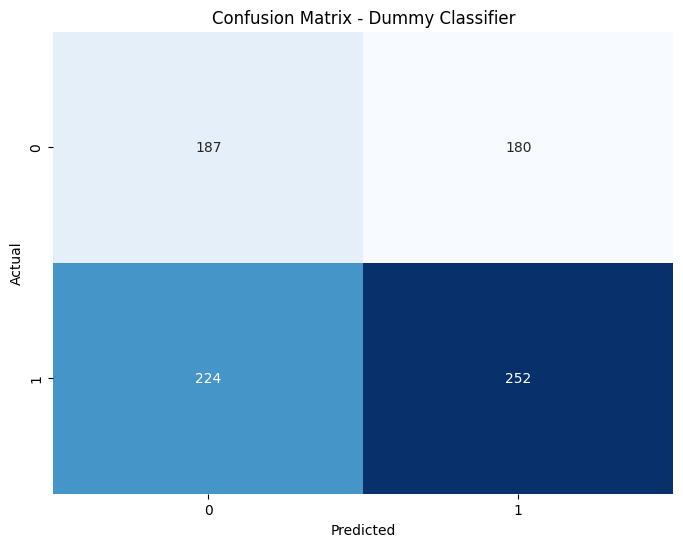

In [ ]:
conf_matrix_dummy = confusion_matrix(y_val, predictions_dummy)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=dummy_model.classes_, yticklabels=dummy_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Dummy Classifier')
plt.show()

####Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)
predictions_log_reg = log_reg_model.predict(X_val)

print(f"Accuracy of Logistic Regression is {round(accuracy_score(y_val, predictions_log_reg),3)*100}%.")
print("Classification Report (Logistic Regression):\n", classification_report(y_val, predictions_log_reg))

Accuracy of Logistic Regression is 43.5%.
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.44      1.00      0.61       367
           1       0.00      0.00      0.00       476

    accuracy                           0.44       843
   macro avg       0.22      0.50      0.30       843
weighted avg       0.19      0.44      0.26       843



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


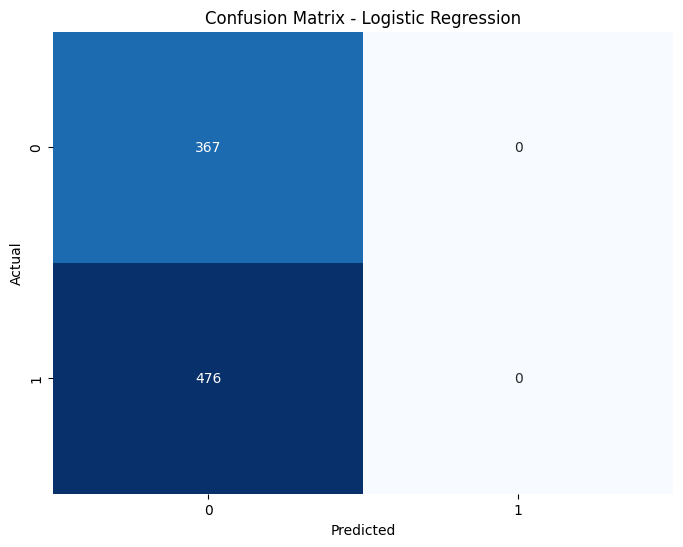

In [ ]:
conf_matrix_log_reg = confusion_matrix(y_val, predictions_log_reg)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=log_reg_model.classes_, yticklabels=log_reg_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

####Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier(random_state=42)
DT_model.fit(X_train, y_train)
predictions_DT = DT_model.predict(X_val)

print(f"Accuracy of Decision Tree is {round(accuracy_score(y_val, predictions_DT),3)*100}%.")
print("Classification Report (Decision Tree):\n", classification_report(y_val, predictions_DT))

Accuracy of Decision Tree is 65.8%.
Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.61      0.62      0.61       367
           1       0.70      0.69      0.70       476

    accuracy                           0.66       843
   macro avg       0.65      0.65      0.65       843
weighted avg       0.66      0.66      0.66       843



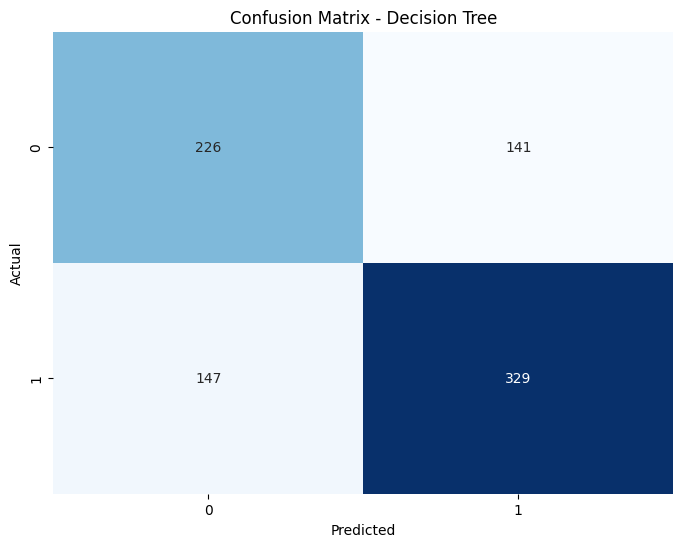

In [ ]:
conf_matrix_DT = confusion_matrix(y_val, predictions_DT)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_DT, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=DT_model.classes_, yticklabels=DT_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

####K-nearest Neighbours

The K-Nearest Neighbors (KNN) algorithm may not be the most effective choice for our dataset. KNN operates by grouping the k closest data points into a cluster to make predictions. In our scenario, data points representing the same chemical compound are likely to be the nearest neighbors. Consequently, KNN would tend to classify all k of these points as either linear or non-linear based on the majority in their vicinity. However, this approach overlooks the fact that each graph representing a chemical compound can have a varying mix of linear and non-linear points. As a result, KNN's methodology might oversimplify the complexity inherent in our dataset, leading to less accurate predictions.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
predictions_knn = knn_model.predict(X_val)

print(f"Accuracy of K-Nearest Neighbors is {round(accuracy_score(y_val, predictions_knn),3)*100}%.")
print("Classification Report (K-Nearest Neighbors):\n", classification_report(y_val, predictions_knn))

Accuracy of K-Nearest Neighbors is 52.1%.
Classification Report (K-Nearest Neighbors):
               precision    recall  f1-score   support

           0       0.45      0.42      0.43       367
           1       0.57      0.60      0.58       476

    accuracy                           0.52       843
   macro avg       0.51      0.51      0.51       843
weighted avg       0.52      0.52      0.52       843



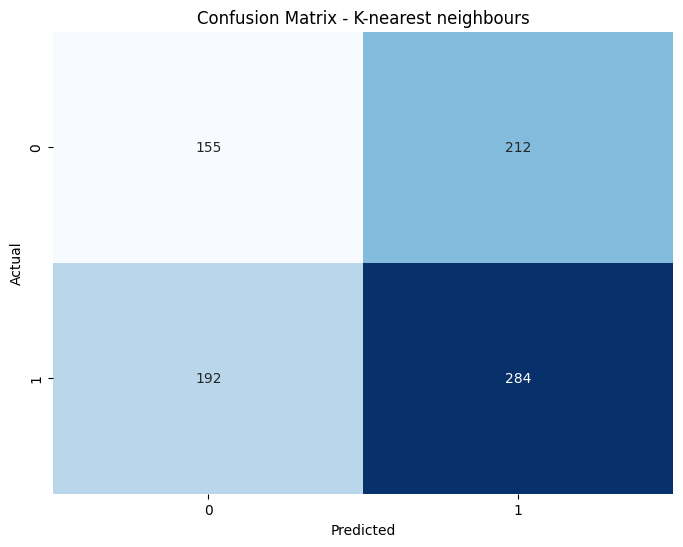

In [ ]:
conf_matrix_knn = confusion_matrix(y_val, predictions_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - K-nearest neighbours')
plt.show()

###Ensemble Learning

####Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model_RF = grid_search.best_estimator_

predictions_best_model_RF = best_model_RF.predict(X_val)
accuracy_best_model_RF = accuracy_score(y_val, predictions_best_model_RF)

print(f"Best Parameters: {best_params}")
print(f"Accuracy of Random Forest is {round(accuracy_best_model_RF, 3)*100} %.")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy of Random Forest is 77.5 %.


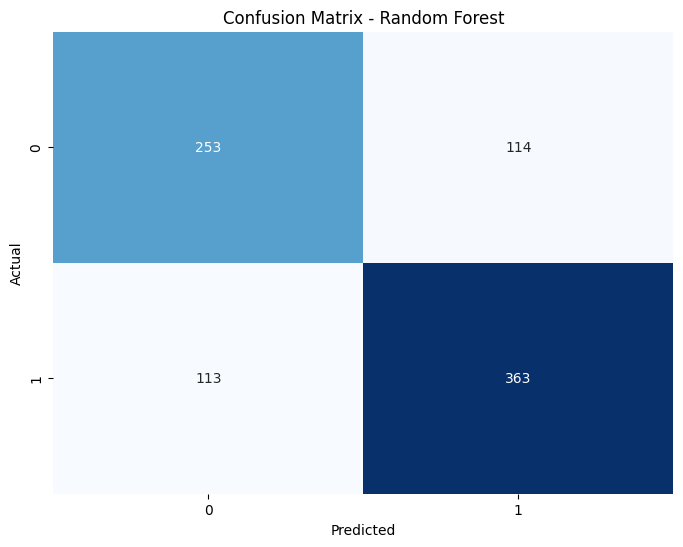

In [ ]:
conf_matrix_RF = confusion_matrix(y_val, predictions_best_model_RF)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_RF, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_model_RF.classes_, yticklabels=best_model_RF.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

####AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

estimator = DecisionTreeClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [1, 2, 3, 4]
}

ada_boost = AdaBoostClassifier(estimator=estimator, random_state=1)
grid_search = GridSearchCV(ada_boost, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model_ada = grid_search.best_estimator_

predictions_best_model_ada = best_model_ada.predict(X_val)
accuracy_best_model_ada = accuracy_score(y_val, predictions_best_model_ada)

print(f"Best Parameters: {best_params}")
print(f"Accuracy of Adaptive Boosting Classifier is {round(accuracy_best_model_ada, 3)*100} %.")

Best Parameters: {'estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 50}
Accuracy of Adaptive Boosting Classifier is 74.4 %.


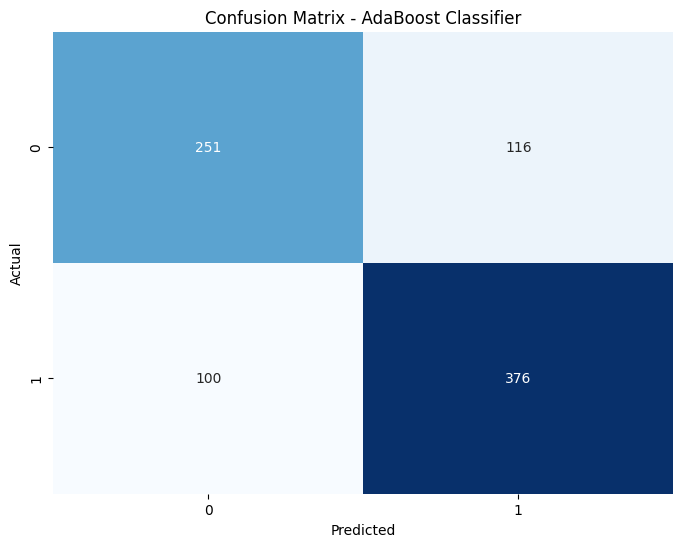

In [ ]:
conf_matrix_ada = confusion_matrix(y_val, predictions_best_model_ada)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ada, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_model_ada.classes_, yticklabels=best_model_ada.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AdaBoost Classifier')
plt.show()

####Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt']
}

gbm = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model_gradientb = grid_search.best_estimator_

predictions_best_model_gradientb = best_model_gradientb.predict(X_val)
accuracy_best_model_gradientb = accuracy_score(y_val, predictions_best_model_gradientb)

print(f"Best Parameters: {best_params}")
print(f"Accuracy of Gradient Boosting Classifier is {round(accuracy_best_model_gradientb, 3)*100} %.")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy of Gradient Boosting Classifier is 73.5 %.


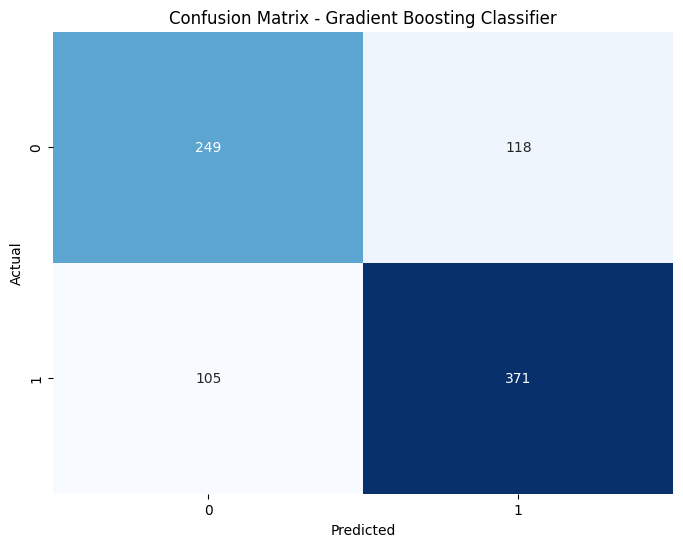

In [ ]:
conf_matrix_gbm = confusion_matrix(y_val, predictions_best_model_gradientb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_model_gradientb.classes_, yticklabels=best_model_gradientb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.show()

####XGBoost

In [ ]:
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model_xgb = grid_search.best_estimator_

predictions_best_model_xgb = best_model_xgb.predict(X_val)
accuracy_best_model_xgb = accuracy_score(y_val, predictions_best_model_xgb)

print(f"Best Parameters: {best_params}")
print(f"Accuracy of XGBoost Classifier is {round(accuracy_best_model_xgb, 3)*100} %.")

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}
Accuracy of XGBoost Classifier is 75.8 %.


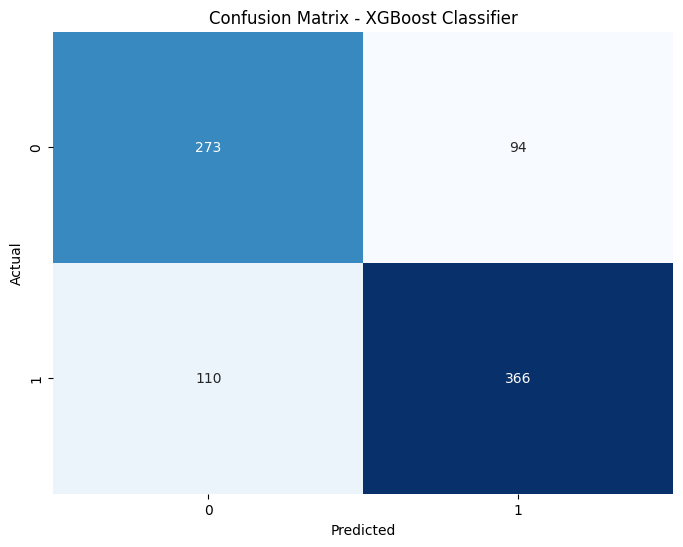

In [ ]:
conf_matrix_xgb = confusion_matrix(y_val, predictions_best_model_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_model_xgb.classes_, yticklabels=best_model_xgb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()